In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


writer = SummaryWriter('../../runs/simple_transformer')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [2]:
data = pd.read_csv("../../data/Dataset_English_Hindi.csv")
data.sample(5)

,English,Hindi
111234,And together with their young teachers at the ...,युवा प्रशिक्षकों के नेतृत्व में हाथियों के ये ...
114491,Some phone have touch screen.,कुछ फोन में स्पर्शस्क्रीन शामिल हैं.
8452,He must also keep away from all useless works.,अन्य व्यर्थ कर्मों से भी अपने आप को दूर रखा जा...
64675,Article 19 also gives a citizen the right of f...,अनुच्छेद 19 भी नागरिक को बोलने की आजादी का अधि...
77582,He thinks that his left hand fast bowling is T...,उनका मानना यह भी है कि बायें हाथ की तेज गेंद त...


In [3]:
mask = data['English'].apply(lambda x: isinstance(x, str)) & data['Hindi'].apply(lambda x: isinstance(x, str))
data = data.loc[mask].copy()
data['English'] = data['English'].str.lower()
data['Hindi'] = data['Hindi'].str.lower()

In [4]:
MAX_SENT_LEN = 15
data = data[data['English'].str.split().apply(len) < MAX_SENT_LEN].copy()
data.reset_index(drop=True, inplace=True)
print(f"Rows after filtering: {len(data)}")

Rows after filtering: 77743


<Axes: title={'center': 'Distribution of English Sentence Lengths'}, ylabel='Frequency'>

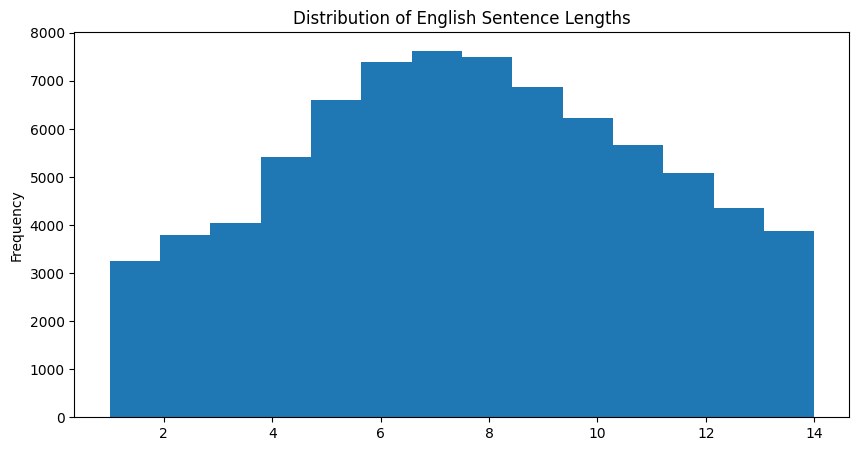

In [5]:
data['English'].str.split().apply(len).plot(kind='hist', bins=14, title='Distribution of English Sentence Lengths', figsize=(10, 5))

In [6]:
class Tokenizer:
    def __init__(self, texts):
        self.oov_token = "<|unknown|>"
        self.start_token = "<|startoftext|>"
        self.end_token = "<|endoftext|>"
        self.padding_token = "<|pad|>"
        self.word_index = {self.oov_token: 0, self.start_token: 1, self.end_token: 2, self.padding_token: 3}
    
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')

            text = text.split()
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index)
        self.index_word = {idx : word for word, idx in self.word_index.items()}

        self.vocab_size = len(self.word_index)
    def encode(self, texts):
        tokenized_texts = []
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')
            tokenized_text = []
            text = text.split()
            for word in text:
                tokenized_text.append(self.word_index.get(word, self.word_index[self.oov_token]))
            tokenized_texts.append(tokenized_text)
        return tokenized_texts
    def decode(self, sequences):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = []
            for index in sequence:
                decoded_text.append(self.index_word.get(index, self.oov_token))
            decoded_texts.append(' '.join(decoded_text))
        return decoded_texts

In [7]:
eng_tokenizer = Tokenizer(data['English'])
hin_tokenizer = Tokenizer(data['Hindi'])
print(f"English Vocabulary Size: {eng_tokenizer.vocab_size}")# 80223
print(f"Hindi Vocabulary Size: {hin_tokenizer.vocab_size}")# 85059

English Vocabulary Size: 43114
Hindi Vocabulary Size: 43014


In [8]:
tokenized_text = eng_tokenizer.encode(["hello how are you raj neelam gaurav convolution", "this is a test", "what is your name"])
print(tokenized_text)
print(eng_tokenizer.decode(tokenized_text))
print()
tokenized_text = hin_tokenizer.encode(["नमस्ते आप कैसे हैं राज नीलम गौरव कन्वोल्यूशन", "यह एक परीक्षण है", "तुम्हारा नाम क्या है"])
print(tokenized_text)
print(hin_tokenizer.decode(tokenized_text))

[[6, 81, 82, 61, 8265, 26950, 0, 0], [93, 103, 109, 2143], [122, 103, 182, 305]]
['hello how are you raj neelam <|unknown|> <|unknown|>', 'this is a test', 'what is your name']

[[27204, 121, 122, 123, 3304, 28590, 5205, 0], [142, 110, 14353, 79], [403, 432, 113, 79]]
['नमस्ते आप कैसे हैं राज नीलम गौरव <|unknown|>', 'यह एक परीक्षण है', 'तुम्हारा नाम क्या है']


In [9]:
data = data.sample(frac=1).reset_index(drop=True)
data, test_data = train_test_split(data, test_size=0.1)
len(data), len(test_data)

(69968, 7775)

In [10]:
EMBED_DIM = 256
BATCH_SIZE = 128
NEM_LAYER = 4
DROPOUT_RATE = 0.1

START_LR = 0.001
END_LR = 0.00005
TOTAL_EPOCHS = 30

In [11]:
class MyDataset(Dataset):
    def __init__(self, data, eng_tokenizer, hin_tokenizer):
        self.data = data
        self.eng_tokenizer = eng_tokenizer
        self.hin_tokenizer = hin_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng_text = self.data.iloc[idx]['English']
        hin_text = self.data.iloc[idx]['Hindi']

        eng_tokenized = self.eng_tokenizer.encode([eng_text])[0]
        if len(eng_tokenized) > MAX_SENT_LEN:
            eng_tokenized = eng_tokenized[:MAX_SENT_LEN]

        eng_padded = [self.eng_tokenizer.word_index[self.eng_tokenizer.padding_token]] * (MAX_SENT_LEN - len(eng_tokenized)) + eng_tokenized

        hin_tokenized = self.hin_tokenizer.encode([hin_text])[0]

        if len(hin_tokenized) > MAX_SENT_LEN - 2:
            hin_tokenized = hin_tokenized[:MAX_SENT_LEN - 2]
        hin_padded = [self.hin_tokenizer.word_index[self.hin_tokenizer.start_token]] + hin_tokenized + [self.hin_tokenizer.word_index[self.hin_tokenizer.end_token]] + [self.hin_tokenizer.word_index[self.hin_tokenizer.padding_token]] * (MAX_SENT_LEN - len(hin_tokenized) - 2)

        return {
            'eng_input': torch.tensor(eng_padded),
            'hin_target': torch.tensor(hin_padded)
        }

dataset = DataLoader(MyDataset(data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(MyDataset(test_data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)

In [12]:
def create_positional_encoding(context, dimension):
    pos = np.arange(context)[:, np.newaxis]
    div_term = 1 / (10000 ** (np.arange(0, dimension, 2) / dimension))
    
    enc = np.zeros((context, dimension))
    enc[:, 0::2] = np.sin(pos * div_term)
    enc[:, 1::2] = np.cos(pos * div_term)
    return enc

In [13]:
class Self_Attention(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Q = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.K = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.V = nn.Linear(EMBED_DIM, EMBED_DIM)
    
    def forward(self, x):
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)

        attention_scores = q @ k.transpose(-2, -1)
        scores = attention_scores / (EMBED_DIM ** 0.5)
        scores = scores.softmax(dim=-1)

        output = torch.matmul(scores, v)
        return output    


In [14]:
class Masked_Self_Attention(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Q = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.K = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.V = nn.Linear(EMBED_DIM, EMBED_DIM)
    
    def forward(self, x):
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)

        attention_scores = q @ k.transpose(-2, -1)
        scores = attention_scores / (EMBED_DIM ** 0.5)

        B, C, _ = x.shape
        mask = torch.tril(torch.ones(C, C, device=x.device)).bool()
        scores = scores.masked_fill(mask == 0, -1e9)

        scores = scores.softmax(dim=-1)

        output = torch.matmul(scores, v)
        return output    

    # def forward(self, x):
    #     q = self.Q(x)
    #     k = self.K(x)
    #     v = self.V(x)

    #     attention_scores = q @ k.transpose(-2, -1)
    #     scores = attention_scores / (EMBED_DIM ** 0.5)

    #     B, C, _ = x.shape
    #     # 1. Causal mask
    #     causal_mask = torch.tril(torch.ones(C, C, device=x.device)).bool()

    #     # 2. Padding mask
    #     # Detect padding positions from embeddings (safe assumption: pad embedding is consistent)
    #     pad_mask = (x.abs().sum(dim=-1) != 0)  # (B, C)
    #     pad_mask = pad_mask.unsqueeze(1).expand(B, C, C)

    #     # Combine masks
    #     combined_mask = causal_mask & pad_mask

    #     scores = scores.masked_fill(~combined_mask, -1e9)

    #     scores = scores.softmax(dim=-1)

    #     output = torch.matmul(scores, v)
    #     return output    


In [15]:
class Cross_Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.Q = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.K = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.V = nn.Linear(EMBED_DIM, EMBED_DIM)
    def forward(self, hin_vec, eng_vec):
        Q = self.Q(hin_vec)
        K = self.K(eng_vec)
        V = self.V(eng_vec)
        
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (EMBED_DIM ** 0.5)
        scores = attention_scores.softmax(dim=-1)

        output = torch.matmul(scores, V)
        return output    


In [16]:
class Transformer_Encoder_Block(nn.Module):
    def __init__(self): # inp_dim is vocab size of the english tokenizer
        super().__init__()
        self.self_attention = Self_Attention()
        self.norm1 = nn.LayerNorm(EMBED_DIM)
        self.norm2 = nn.LayerNorm(EMBED_DIM)
        self.ffnn = nn.Sequential(
            nn.Linear(EMBED_DIM, 3*EMBED_DIM),
            nn.ReLU(),
            nn.Linear(3*EMBED_DIM, EMBED_DIM)
        )
        self.dropout1 = nn.Dropout(DROPOUT_RATE)
        self.dropout2 = nn.Dropout(DROPOUT_RATE)


    def forward(self, words_vec):  
        informed_words = self.self_attention(words_vec)   # (B, C, E) Attention
        informed_words = self.dropout1(informed_words) # droupout

        words_vec = words_vec + informed_words
        words_vec = self.norm1(words_vec) # (B, C, E) Add & Normalize

        thought_words = self.ffnn(words_vec) # feef forward neural network

        thought_words = self.dropout2(thought_words) # droupout
        words_vec = words_vec + thought_words
        words_vec = self.norm2(words_vec) # (B, C, E) Add & Normalize

        return words_vec
        

In [17]:
class Full_Encoder(nn.Module):
    def __init__(self, input_dim, num_layers):
        super().__init__()
        self.word_embedding = nn.Embedding(input_dim, EMBED_DIM)
        pe = torch.tensor(
            create_positional_encoding(MAX_SENT_LEN, EMBED_DIM),
            dtype=torch.float32
        )
        self.register_buffer("positional_encoding", pe) # register and save positional encodings
        self.blocks = nn.ModuleList(
            [Transformer_Encoder_Block() for _ in range(num_layers)]
        )

    def forward(self, x):                             # (B, C)
        embedded = self.word_embedding(x)               # (B, C, E) batch, context_length, embedding
        words_vec = self.positional_encoding[:embedded.size(1)] + embedded   # (B, C, E) Adding positonal embeddings
        
        for block in self.blocks:
            words_vec = block(words_vec)
        
        return words_vec

In [18]:
class Transformer_Decoder_Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.attention = Masked_Self_Attention()
        self.cross_attention = Cross_Attention() # To do
        self.feed_forward = nn.Sequential(
            nn.Linear(EMBED_DIM, 3 * EMBED_DIM),
            nn.ReLU(),
            nn.Linear(3 * EMBED_DIM, EMBED_DIM)
        )
        self.norm1 = nn.LayerNorm(EMBED_DIM)
        self.norm2 = nn.LayerNorm(EMBED_DIM)
        self.norm3 = nn.LayerNorm(EMBED_DIM)
        self.dropout1 = nn.Dropout(DROPOUT_RATE)
        self.dropout2 = nn.Dropout(DROPOUT_RATE)
        self.dropout3 = nn.Dropout(DROPOUT_RATE)
    
    def forward(self, word_vec, encoder_output):
        informed_words = self.attention(word_vec)
        informed_words = self.dropout1(informed_words)
        word_vec = self.norm1(informed_words + word_vec)

        informed_words = self.cross_attention(word_vec, encoder_output)
        informed_words = self.dropout2(informed_words)
        word_vec = self.norm2(informed_words + word_vec)

        informed_words = self.feed_forward(word_vec)
        informed_words = self.dropout3(informed_words)
        word_vec = self.norm3(informed_words + word_vec)
        
        return word_vec

In [19]:
class Full_Decoder(nn.Module):
    def __init__(self, hindi_input_dim, num_layers): # hindi input vocab size
        super().__init__()
        self.hindi_embedding = nn.Embedding(hindi_input_dim, EMBED_DIM)
        pe = torch.tensor(
            create_positional_encoding(MAX_SENT_LEN, EMBED_DIM),
            dtype=torch.float32
        )
        self.register_buffer("positional_encoding", pe) # register and save positional encodings
        self.blocks = nn.ModuleList(
            [Transformer_Decoder_Block() for _ in range(num_layers)]
        )
        self.unembedding = nn.Linear(EMBED_DIM, hindi_input_dim)


    def forward(self, x, encoder_output):                             # (B, C)
        hindi_embedded = self.hindi_embedding(x)               # (B, C, E) batch, context_length, embedding
        hindi_words_vec = self.positional_encoding[:hindi_embedded.size(1)] + hindi_embedded   # (B, C, E) Adding positonal embeddings
        
        for block in self.blocks:
            hindi_words_vec = block(hindi_words_vec, encoder_output)
        
        hindi_words_vec_logits = self.unembedding(hindi_words_vec)
        return hindi_words_vec_logits

In [20]:
class Language_Transformer(nn.Module):
    def __init__(self, english_vocab, hindi_vocab, num_layers):
        super().__init__()
        self.encoder = Full_Encoder(english_vocab, num_layers)
        self.decoder = Full_Decoder(hindi_vocab, num_layers)
    
    def forward(self, english_tokens, hindi_tokens):
        english_encoder_output = self.encoder(english_tokens)
        hindi_vec = self.decoder(hindi_tokens, english_encoder_output)
        return hindi_vec

In [21]:
model = Language_Transformer(eng_tokenizer.vocab_size, hin_tokenizer.vocab_size, NEM_LAYER).to(device)

data_iter = iter(dataset)
sample_batch = next(data_iter)
X_sample = sample_batch['eng_input'].to(device)
y_sample = sample_batch['hin_target'].to(device)
writer.add_graph(model, [X_sample, y_sample])

In [22]:
# load saved weights and set model to evaluation mode

# checkpoint_path = "models/simple_transformer_1.pth"
# state_dict = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(state_dict)
# model.to(device)
# model.train()

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index=hin_tokenizer.word_index[hin_tokenizer.padding_token])
optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)

In [24]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    # print(f"Model saved to {filepath}")
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [25]:
def get_linear_lr(epoch, total_epochs, start_lr, end_lr):
    """
    Calculates a linearly interpolated learning rate.
    """
    if epoch >= total_epochs:
        return end_lr
    
    # Formula: start + (end - start) * (progress)
    lr = start_lr + (end_lr - start_lr) * (epoch / total_epochs)
    return lr

In [26]:
for epoch in range(0, TOTAL_EPOCHS):
    lr = get_linear_lr(epoch, TOTAL_EPOCHS, START_LR, END_LR)
    optimizer.param_groups[0]['lr'] = lr
    tqdm_bar = tqdm(dataset)
    model.train()
    

    for i, batch in enumerate(tqdm_bar):
        # load batch to device
        X, y = batch['eng_input'].to(device), batch['hin_target'].to(device)

        # print("Max Hindi token id:", y.max().item())
        # print("Hindi embedding vocab size:", model.decoder.hindi_embedding.num_embeddings)
        # break

        decoder_input = y[:, :-1]
        decoder_target = y[:, 1:]

        # forward pass
        logits = model(X, decoder_input)
        loss = criterion(
            logits.view(-1, logits.size(-1)),
            decoder_target.reshape(-1)
        )    
        writer.add_scalar('Training Loss', loss.item(), epoch * len(tqdm_bar) + i)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch * len(tqdm_bar) + i)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tqdm_bar.set_description(f"Epoch: {epoch+1}")

        if i % 500 == 0:
            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_histogram(f'Weights/{name}', param, global_step=i)
                    # Logging gradients
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, global_step=i)
    
    k=0
    sumer=0
    for d in test_dataset:

        model.eval()
        tX, ty = d['eng_input'].to(device), d['hin_target'].to(device)
        decoder_input = ty[:, :-1]
        decoder_target = ty[:, 1:]
        # test loss
        test_logits = model(tX, decoder_input)
        test_loss = criterion(test_logits.view(-1, test_logits.size(-1)), decoder_target.reshape(-1))
        sumer+=test_loss.item()
        k+=1
    print("Average Test Loss: ",sumer/(k+0.00001))
    writer.add_scalar('Test Loss', sumer/(k+0.00001), epoch)
    
    save_model(model, f"../../models/simple_transformer_epoch_{epoch+1}.pth")
writer.close()
    

Epoch: 1: 100%|██████████| 547/547 [03:11<00:00,  2.85it/s]


Average Test Loss:  5.787992333717057


Epoch: 2: 100%|██████████| 547/547 [02:48<00:00,  3.25it/s]


Average Test Loss:  5.086605363800126


Epoch: 3: 100%|██████████| 547/547 [03:15<00:00,  2.79it/s]


Average Test Loss:  4.647401548111442


Epoch: 4: 100%|██████████| 547/547 [03:24<00:00,  2.67it/s]


Average Test Loss:  4.452782553675774


Epoch: 5: 100%|██████████| 547/547 [03:01<00:00,  3.01it/s]


Average Test Loss:  4.392344677142281


Epoch: 6: 100%|██████████| 547/547 [02:30<00:00,  3.64it/s]


Average Test Loss:  4.411887082709811


Epoch: 7: 100%|██████████| 547/547 [02:57<00:00,  3.08it/s]


Average Test Loss:  4.4481219128790235


Epoch: 8: 100%|██████████| 547/547 [03:17<00:00,  2.77it/s]


Average Test Loss:  4.525313921422557


Epoch: 9: 100%|██████████| 547/547 [03:22<00:00,  2.70it/s]


Average Test Loss:  4.624467986668736


Epoch: 10:  10%|▉         | 52/547 [00:16<02:40,  3.09it/s]


KeyboardInterrupt: 

In [28]:
user_query = input("Enter English Sentence To Translate")

def translate(sentence):
    model.eval()
    # Tokenize English sentence
    eng_tokenized = eng_tokenizer.encode([sentence])[0]
    if len(eng_tokenized) > MAX_SENT_LEN:
        eng_tokenized = eng_tokenized[:MAX_SENT_LEN]
    eng_padded = [eng_tokenizer.word_index[eng_tokenizer.padding_token]] * (MAX_SENT_LEN - len(eng_tokenized)) + eng_tokenized
    eng_tensor = torch.tensor([eng_padded]).to(device)

    # Encode
    with torch.no_grad():
        encoder_output = model.encoder(eng_tensor)

    # Decode (Auto-regressive)
    hin_tokenized = [hin_tokenizer.word_index[hin_tokenizer.start_token]]
    
    for _ in range(MAX_SENT_LEN):
        hin_tensor = torch.tensor([hin_tokenized]).to(device)
        with torch.no_grad():
            logits = model.decoder(hin_tensor, encoder_output)
        
        # Get last token logits
        last_token_logits = logits[0, -1, :]
        predicted_token_id = torch.argmax(last_token_logits).item()
        
        if predicted_token_id == hin_tokenizer.word_index[hin_tokenizer.end_token]:
            break
            
        hin_tokenized.append(predicted_token_id)
        
    # Decode to text
    translated_text = hin_tokenizer.decode([hin_tokenized[1:]])[0] # Skip start token
    return translated_text

print(f"Input: {user_query}")
print(f"Translation: {translate(user_query)}")


Input: hello brother how are you can you open the door for me
Translation: मजबूत भाई आप मेरे लिए योग्यताएं कर सकते हैं क्या मैं आप मेरे
